In [1]:
import sys
import os

sys.path.append('/users/PCON0022/shiya/Database/single/Sarsgt/attention_update')

In [1]:
import numpy as np
import time
import re
import random
from tqdm import tqdm

import anndata as ad
import pandas as pd
import numpy as np
import os
import anndata
import scipy.sparse
from scipy.sparse import csc_matrix

from utils import*
from conv import *
from Sarsgt_model import *

In [2]:
import warnings
from warnings import filterwarnings
import torch.cuda as cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, uniform
from torch_geometric.utils import softmax as Softmax
from torchmetrics.functional import pairwise_cosine_similarity
import math
import scanpy as sc

filterwarnings("ignore")
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import argparse
parser = argparse.ArgumentParser(description='Training GNN on gene cell graph')
parser.add_argument('--fi', type=int, default=0)
parser.add_argument('--labsm', type=float, default=0.3) # The rate of LabelSmoothing
parser.add_argument('--wd', type=float, default=0.1)
parser.add_argument('--lr', type=float, default=0.0005)
parser.add_argument('--n_hid', type=int, default=104)
parser.add_argument('--nheads', type=int, default=8)
parser.add_argument('--nlayers', type=int, default=3)
parser.add_argument('--cell_size', type=int, default=30)
parser.add_argument('--neighbor', type=int, default=20)
parser.add_argument('--egrn', type=bool, default=True)
#parser.add_argument('--output_file', type=str, default='/users/PCON0022/duanmaoteng/Final_HGT/GSE201402/DeepSars-main/Model_test')
args = parser.parse_args([])

#output_file = args.output_file
fi=args.fi
labsm = args.labsm
lr = args.lr
wd = args.wd
n_hid = args.n_hid
nheads = args.nheads
nlayers = args.nlayers
cell_size = args.cell_size
neighbor = args.neighbor
egrn = args.egrn

In [3]:
import anndata as ad
import pandas as pd
import numpy as np
import os
import anndata
import h5py
import scipy.sparse
from scipy.sparse import csc_matrix

In [4]:
from scipy.io import mmread
import scrublet as scr
import harmonypy as hm

In [5]:
from anndata import AnnData

In [6]:
print("Scanpy:", sc.__version__)
#print("Scrublet:", scr.__version__)
print("AnnData:", ad.__version__)

Scanpy: 1.9.1
AnnData: 0.8.0


#### Data preprocessing

In [29]:
mpl.rcParams['pdf.fonttype'] = 42   # Type-42 (TrueType)
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [7]:
gene = pd.read_csv("genes.tsv",sep='\t',header=None)

In [18]:
gene

0             1
0      ENSG00000243485    MIR1302-10
1      ENSG00000237613       FAM138A
2      ENSG00000186092         OR4F5
3      ENSG00000238009  RP11-34P13.7
4      ENSG00000239945  RP11-34P13.8
...                ...           ...
32733  ENSG00000215635    AC145205.1
32734  ENSG00000268590         BAGE5
32735  ENSG00000251180    CU459201.1
32736  ENSG00000215616    AC002321.2
32737  ENSG00000215611    AC002321.1

[32738 rows x 2 columns]

In [22]:
cSLE4_b = pd.read_csv("cSLE4_barcodes.tsv",sep='\t',header=None)

In [23]:
cSLE4_b

0
0     AAACCTGAGAAGATTC-1
1     AAACCTGAGGCAAAGA-1
2     AAACCTGAGTCAATAG-1
3     AAACCTGAGTTAGGTA-1
4     AAACCTGCAATAACGA-1
...                  ...
6166  TTTGTCATCGCCAAAT-1
6167  TTTGTCATCGGCGCAT-1
6168  TTTGTCATCGGGAGTA-1
6169  TTTGTCATCGGTCCGA-1
6170  TTTGTCATCTGAAAGA-1

[6171 rows x 1 columns]

In [24]:
cSLE4 = ad.read_mtx("cSLE4_matrix.mtx")
cSLE4

AnnData object with n_obs × n_vars = 32738 × 6171

In [25]:
gene_cell = cSLE4
gene_names = gene
gene_cells = cSLE4_b

In [26]:
gene_cell.obs_names = gene_names[1]
gene_cell.var_names = gene_cells[0]

RNA_matrix = gene_cell.X

cell_num = RNA_matrix.shape[1]
gene_num = RNA_matrix.shape[0]

In [27]:
from anndata import AnnData
# Create an AnnData object
adata = AnnData(X=RNA_matrix.T)  # （cell x gene）
adata.var_names =  gene_names[1]
adata.obs_names = gene_cells[0]

In [15]:
# Obtain the boolean index of var_names to mark the first occurrence of each element
unique_var_mask = ~adata.var_names.duplicated(keep='first')

# Filter out duplicate genes, keeping only the first occurrence.
adata = adata[:, unique_var_mask]

In [16]:
# 2. Quality control
# Filter out low-quality cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['doublet_scores'] = doublet_scores
adata = adata[~predicted_doublets, :]

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 3.1%
Estimated detectable doublet fraction = 53.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 3.8 seconds


In [19]:
scipy.io.mmwrite('afilter_cSLE4_matrix.mtx', adata.X)
adata.var_names.to_series().to_csv('afilter_cSLE4_gene.tsv', sep='\t', header=False, index=False)
adata.obs_names.to_series().to_csv('afilter_cSLE4_cell.tsv', sep='\t', header=False, index=False)

In [20]:
adata.write("cSLE4_processed_data.h5ad")

#### Load the data

In [6]:
concatenated_matrix = ad.read_mtx('afilter_cSLE4_matrix.mtx')
concatenated_matrix

AnnData object with n_obs × n_vars = 5980 × 16227

In [7]:
concatenated = pd.read_csv("afilter_cSLE4_cell.tsv",sep='\t',header=None)
concatenated

0
0     AAACCTGAGAAGATTC-1
1     AAACCTGAGGCAAAGA-1
2     AAACCTGAGTCAATAG-1
3     AAACCTGCAATAACGA-1
4     AAACCTGCACGTGAGA-1
...                  ...
5975  TTTGTCATCGCCAAAT-1
5976  TTTGTCATCGGCGCAT-1
5977  TTTGTCATCGGGAGTA-1
5978  TTTGTCATCGGTCCGA-1
5979  TTTGTCATCTGAAAGA-1

[5980 rows x 1 columns]

In [8]:
concatenated_f = pd.read_csv("afilter_cSLE4_gene.tsv",sep= '\t',header = None)
concatenated_f

0
0       RP11-34P13.7
1         AL627309.1
2         AP006222.2
3      RP4-669L17.10
4      RP11-206L10.3
...              ...
16222     AC011043.1
16223     AL592183.1
16224     AC011841.1
16225     AL354822.1
16226        KIR2DL2

[16227 rows x 1 columns]

In [9]:
gene_cell = concatenated_matrix
cell_names = concatenated
gene_names = concatenated_f

adata = AnnData(X=gene_cell)
adata.obs_names = cell_names[0]
adata.var_names = gene_names[0]

RNA_matrix = adata.X.T

gene_num = RNA_matrix.shape[0]
cell_num = RNA_matrix.shape[1]

print(f"Number of cells: {cell_num}")
print(f"Number of genes: {gene_num}")

Number of cells: 5980
Number of genes: 16227


In [11]:
RNA_matrix.shape

(16227, 5980)

In [ ]:
device = torch.device("cuda" if cuda.is_available() else "cpu")
print('You will use : ',device)
# clustering result by scanpy
#initial_pre = initial_clustering(RNA_matrix,custom_resolution=0.8,custom_n_neighbors=10)
#initial_pre = initial_clustering(RNA_matrix.copy())
initial_pre = initial_clustering(RNA_matrix, custom_n_neighbors=15, n_pcs=30, custom_resolution=1, use_rep=None)
cluster_ini_num = len(set(initial_pre)) 
ini_p1 = [int(i) for i in initial_pre] 

indices, Node_Ids, dic = batch_select_whole (RNA_matrix, neighbor = [neighbor], cell_size=cell_size)
n_batch = len(indices)

# Reduce the dimensionality of features for cell, gene, and peak data.
node_model = NodeDimensionReduction(RNA_matrix, indices, ini_p1, n_hid=n_hid, n_heads=nheads, 
                                    n_layers=nlayers,labsm=labsm, lr=lr, wd=wd, device=device, num_types=2, num_relations=1, epochs=20)
gnn = node_model.train_model(n_batch=n_batch)
SarsGT_model = SarsGT(gnn=gnn, labsm=labsm, n_hid=n_hid, n_batch=n_batch, device=device,lr=lr,wd=wd, num_epochs=20)
SarsGT_gnn = SarsGT_model.train_model(indices=indices,RNA_matrix=RNA_matrix,ini_p1=ini_p1)

#SarsGT_result = SarsGT_pred(RNA_matrix,SarsGT_gnn=SarsGT_gnn, indices=indices, 
                    #nodes_id=Node_Ids, cell_size=cell_size, device=device, gene_names=gene_names)

SarsGT_result = SarsGT_pred(RNA_matrix,SarsGT_gnn=SarsGT_gnn, indices=indices, 
                    nodes_id=Node_Ids, cell_size=cell_size, device=device, gene_names=gene_names,node_dim_reduction_model=node_model)

In [14]:
from pathlib import Path

output_path = Path('/users/PCON0022/shiya/Database/single/data1/cSLE4/output_A')

np.save(output_path / "Node_Ids.npy", Node_Ids)
np.save(output_path /"pred.npy", SarsGT_result['pred_label'])
np.save(output_path /"cell_embedding.npy", SarsGT_result['cell_embedding'])
np.save(output_path /"attention_weights.npy", SarsGT_result['attention_weights'])

In [10]:
Node_Ids = np.load('/users/PCON0022/wangxiaoying/Syao/data1_example/cSLE4/output_A_n/Node_Ids.npy' )
pred_label = np.load("/users/PCON0022/wangxiaoying/Syao/data1_example/cSLE4/output_A_n/pred.npy")
cell_embedding = np.load("/users/PCON0022/wangxiaoying/Syao/data1_example/cSLE4/output_A_n/cell_embedding.npy")

In [11]:
unique_values = np.unique(pred_label)
print("Unique values in pred_label:", unique_values)

Unique values in pred_label: [ 0  1  2  3  4  5  6  7  8  9 10]


In [12]:
nodes_id = list(Node_Ids)

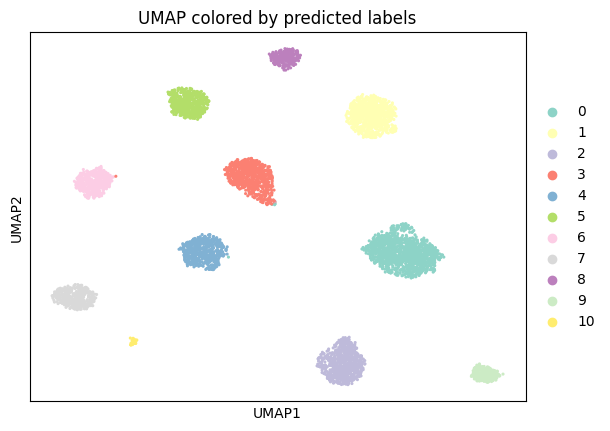

In [16]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

adata = sc.AnnData(cell_embedding)

#adata.obs['label'] = pd.Categorical(list(new_true_label))
adata.obs['pred_label'] = pd.Categorical(np.array(pred_label))
#adata.obs['true_sex_label'] = pd.Categorical(np.array(true_sex_label))
#adata.obs['sex_label'] = 

sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)

# sc.pl.umap(adata, color='label', palette='Set1', title='UMAP colored by true labels')

sc.pl.umap(adata, color='pred_label', palette='Set3', title='UMAP colored by predicted labels')
#sc.pl.umap(adata, color='true_sex_label', palette='Set2', title='UMAP colored by predicted labels')

In [17]:
cluster_counts = adata.obs['pred_label'].value_counts()

print(cluster_counts)

0     1276
1      845
2      734
3      707
4      546
5      524
6      445
7      402
8      248
9      211
10      42
Name: pred_label, dtype: int64


In [18]:
marker = {
    'T Cells': ['CD3D', 'CD3E', 'CD4', 'CD8A', 'CD8B', 'CCR7'],
    #'NK Cells': ['NCAM1', 'KLRD1', 'FCGR3A', 'GNLY'],
    'NK Cells': ['NCAM1', 'KLRD1', 'FCGR3A'],
    #'B Cells': ['CD19', 'CD79A', 'MS4A1', 'IGHD', 'CD27', 'CR2'],
    'B Cells': ['CD19', 'CD79A', 'MS4A1'],
    #'DC': ['HLA-DRA', 'ITGAX','CLEC10A','CD1C'],#CD11C是ITGAX
    #'DC': ['HLA-DRA', 'ITGAX','CD1C'],
    #'DC': [ 'ITGAX','CD1C'],
    'pDC': ['IL3RA', 'CLEC4C', 'LILRA4'],
    #'Plasma Cells': ['MZB1', 'CD27', 'CD38'],
    'Monocytes': ['CD14','CD68','ITGAM','FCGR3A'],
    #'Megakaryocytes': ['ITGA2B', 'MPL','PF4'],
    #'Erythroid Cells':['ALAS2','EPB42'],
    #'Platelet':['ITGA2B','ITGB3','PF4'],
    #'Neutrophils': ['FCGR3B', 'CXCR2'],
    #'Erythroid cells':['ALAS2','EPB42'],
    #'Erythroid Progenitors':['GATA1','KLF1'],
    #'Erythroid Cells':['ALAS2','GYPA']
}

In [19]:
adata =  ad.AnnData(RNA_matrix.transpose(), dtype='int32')
sc.pp.log1p(adata)
adata.var_names=gene_names[0]
adata.obs['pred_type'] = list(np.array(pred_label))
adata.obs['pred_type'] = adata.obs['pred_type'].astype(str)
adata.obs['pred_type'] = adata.obs['pred_type'].astype("category")

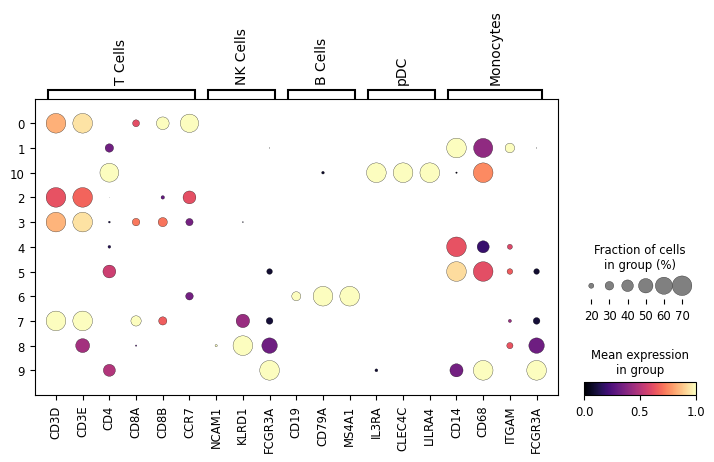

In [20]:
sc.pl.dotplot(
    adata,
    marker,
    groupby='pred_type',
    dot_max=0.7,
    dot_min=0.1,
    color_map='magma',
    standard_scale='var'
)

In [25]:
label_mapping = {
    0: '0:CD8+ Tn',
    1: '1:cM1',
    2: '2:DNT',
    3: '3:CD8+ Tem',
    4: '4:cM2',
    5: '5:cM3',
    6: '6:DNB',
    7: '7:CD8+ CTLs',
    8: '8:CD56dim+ NK',
    9: '9:ncM',
    10: '10:pDCs'
}

In [23]:
label_mapping = {
    0: '0:CD8+ Tn',
    1: '1:cM',
    2: '2:DNT',
    3: '3:CD8+ Tem',
    4: '4:cM',
    5: '5:cM',
    6: '6:DNB',
    7: '7:CD8+ CTLs',
    8: '8:CD56dim+ NK',
    9: '9:ncM',
    10: '10:pDCs'
}

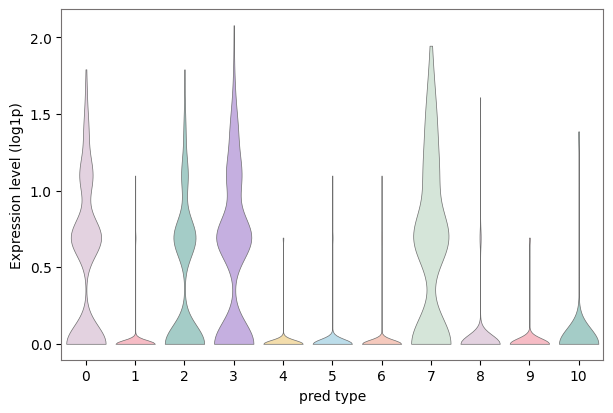

In [38]:
import scanpy as sc
import matplotlib.pyplot as plt

macaron_palette = [
    "#E6CFE2", 
    "#FFB3BE", 
    "#9DD3CC", 
    "#C4A7E8", 
    "#FFE1A0", 
    "#B5E0F1", 
    "#FEC3B4",
    "#D2E8D8", 
]

sc.pl.violin(
    adata,
    keys='CD3G',
    groupby='pred_type',
    palette=macaron_palette,
    title='CD3D Expression by Predicted Type',
    ylabel='Expression level (log1p)',
    stripplot=False,
    show=False,
    frameon=False,
    linewidth=0.5
)

plt.rcParams.update({
    'font.family': 'Arial',
    'axes.linewidth': 0.8,
    'axes.edgecolor': '#767171',  
    'axes.titlecolor': '#000000',  
    'axes.labelcolor': '#000000', 
    'xtick.color': '#000000',     
    'ytick.color': '#000000',
    'figure.facecolor': 'white'
})

plt.gca().spines['bottom'].set_color('#767171') 
plt.gca().spines['left'].set_color('#767171')
plt.gca().title.set_size(12)

plt.tight_layout()

plt.savefig(
    "/users/PCON0022/wangxiaoying/Syao/data1_example/cSLE4/results/CD3G_violin.pdf",
    dpi=300,
    bbox_inches='tight'
)
plt.show()

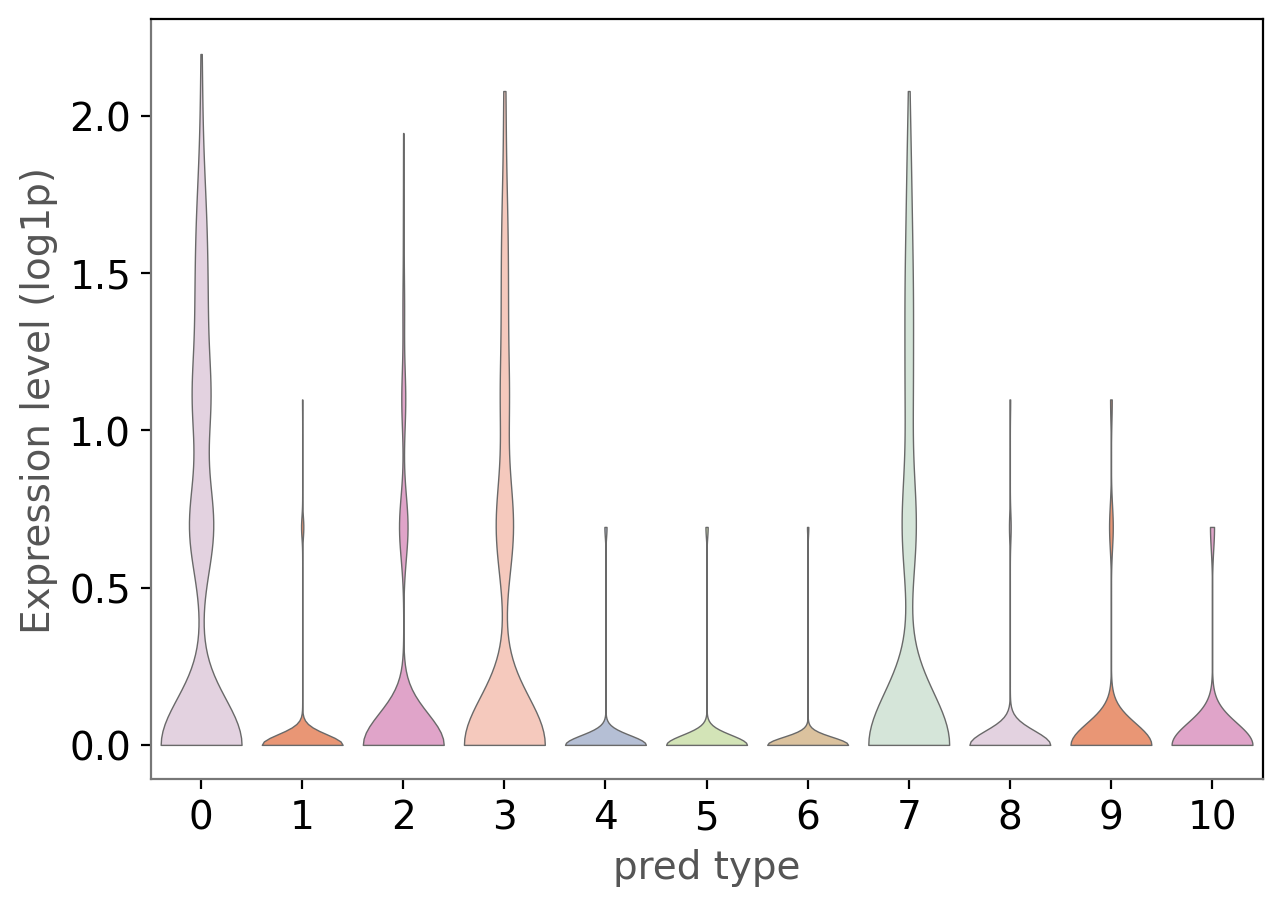

In [52]:
macaron_palette = [
    "#E6CFE2", 
    "#FC8D62",  
    "#EA9ACB", 
    "#FEC3B4",  
    "#AFBDDB",  
    "#D5ECAF", 
    "#E5C494", 
    "#D2E8D8", 
]

sorted_categories = sorted(
    adata.obs['pred_type'].astype(str).unique(),
    key=lambda x: int(x)
)
category_order = pd.CategoricalDtype(categories=sorted_categories, ordered=True)
adata.obs['pred_type'] = adata.obs['pred_type'].astype(str).astype(category_order)

sc.pl.violin(
    adata,
    keys='CD8B',
    groupby='pred_type',
    palette=macaron_palette,
    title='CD3D Expression by Predicted Type',
    ylabel='Expression level (log1p)',
    stripplot=False,
    show=False,
    frameon=False,
    linewidth=0.5
)

plt.rcParams.update({
    'axes.linewidth': 0.8,
    'axes.edgecolor': '#666666',
    'axes.titlecolor': '#444444',
    'axes.labelcolor': '#555555',
    'figure.facecolor': 'white'
})

ax = plt.gca()
ax.grid(False)
ax.spines['bottom'].set_color('#777777')
ax.spines['left'].set_color('#777777')
ax.title.set_size(12)
sc.set_figure_params(figsize=(6.5, 5), dpi=100)

plt.tight_layout()

plt.savefig(
    "/fs/ess/PCON0022/wangxiaoying/sy/plot2/CD8B_violin.pdf",
    dpi=300,
    bbox_inches='tight'
)
plt.show()


In [26]:
adata_label = adata

In [27]:
adata_label.obs['pred_type'] = list(np.array(pred_label))
adata_label.obs['mapped_pred_type'] = adata_label.obs['pred_type'].map(label_mapping)

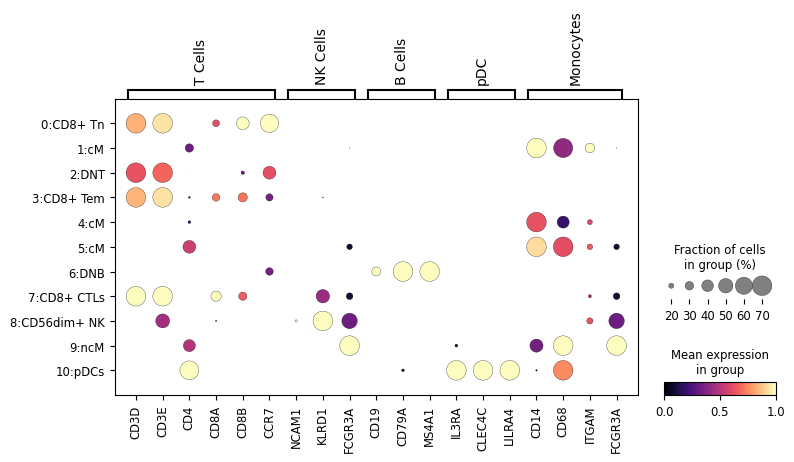

In [26]:
sc.pl.dotplot(
    adata_label,
    marker,
    groupby='mapped_pred_type',
    dot_max=0.7,
    dot_min=0.1,
    color_map='magma',
    standard_scale='var',
    save="dotplot1.svg" 
)

In [29]:
import scanpy as sc
import matplotlib.pyplot as plt

sc.pl.dotplot(
    adata_label,
    marker,
    groupby='mapped_pred_type',
    dot_max=0.7,
    dot_min=0.1,
    color_map='magma',
    standard_scale='var',
    show=False  
)

plt.savefig("/users/PCON0022/wangxiaoying/Syao/data1_example/cSLE4/results/dotplot2.pdf", 
            format="pdf", bbox_inches="tight")
plt.close()


In [28]:
ax = sc.pl.dotplot(
    adata_label,
    marker,
    groupby='mapped_pred_type',
    dot_max=0.7,
    dot_min=0.1,
    color_map='magma',
    standard_scale='var',
    show=False
)

import matplotlib.pyplot as plt
plt.savefig("/fs/ess/PCON0022/wangxiaoying/sy/plot2/cSLE4_dotplot2.pdf", format="pdf", bbox_inches="tight")
plt.close()
plt.show()

#### Identify differentially expressed genes

In [ ]:
adata_d = adata

In [22]:
import scanpy as sc

sc.pp.pca(adata_d, n_comps=50)

sc.tl.dendrogram(adata_d, groupby='pred_type')

if "RP11-1143G9.4" in adata_d.var_names:
    keep_genes = ~adata_d.var_names.isin(["RP11-1143G9.4"])
    adata_d = adata_d[:, keep_genes].copy()  
    print("已过滤基因: RP11-1143G9.4")
else:
    print("基因 RP11-1143G9.4 不存在，无需过滤")
# -----------------------------------------

sc.tl.rank_genes_groups(
    adata_d, groupby="pred_type", use_rep='X_pca',
    method="wilcoxon", key_added="dea_leiden_res1"
)

已过滤基因: RP11-1143G9.4


In [23]:
sc.tl.filter_rank_genes_groups(
    adata_d,
    min_in_group_fraction=0.1,
    max_out_group_fraction=0.3,
    key="dea_leiden_res1",
    key_added="dea_leiden_res1_filtered",
)

In [24]:
degs = sc.get.rank_genes_groups_df(adata_d, group='0', key='dea_leiden_res1_filtered')
degs=degs.dropna()
degs.head(50)

names     scores  logfoldchanges          pvals      pvals_adj
32         PIK3IP1  29.850302        2.086212  8.699913e-196  3.815265e-193
41            LEF1  29.137535        2.566047  1.201870e-186  4.062820e-184
46            CCR7  28.373621        2.669773  4.279765e-177  1.285990e-174
99            CD27  19.164404        1.820418   7.339327e-82   7.442995e-80
100           TCF7  18.855797        1.761403   2.633379e-79   2.621423e-77
101           GYPC  18.596884        1.447418   3.405326e-77   3.328603e-75
102           CD3G  18.494839        1.552063   2.272217e-76   2.194583e-74
104           CD8B  18.007225        2.335285   1.709890e-72   1.567495e-70
106           IL7R  17.711910        1.418105   3.393555e-70   3.025485e-68
112  RP11-291B21.2  15.966042        3.282193   2.203337e-57   1.678467e-55
114         GIMAP7  15.592805        1.533808   8.147564e-55   5.901891e-53
120          NELL2  15.183452        2.621049   4.551859e-52   3.156345e-50
121          RGS10  15.128557        1.196199   1.049717e-51   7.217252e-50
122           TOB1  14.805490        1.261979   1.350008e-49   9.165367e-48
124      PRKCQ-AS1  14.637716        1.981630   1.613983e-48   1.073299e-46
125            MYC  14.614653        1.818393   2.265065e-48   1.494022e-46
126         MGAT4A  14.485265        1.490426   1.501431e-47   9.744891e-46
129      LINC00861  14.207584        1.779004   8.221296e-46   5.170494e-44
131            MAL  14.091223        1.942312   4.300499e-45   2.673559e-43
132         OCIAD2  13.948726        1.542397   3.202753e-44   1.968480e-42
133            LAT  13.829019        1.164463   1.703279e-43   1.031247e-41
136          RCAN3  13.597164        1.831982   4.162615e-42   2.447196e-40
138            CD6  13.553286        1.589797   7.576171e-42   4.402439e-40
140         ARRDC3  13.515714        1.432875   1.263238e-41   7.268547e-40
142          SEPT6  13.268219        1.095606   3.538930e-40   1.986944e-38
143          ACAP1  13.241809        1.051445   5.032188e-40   2.815596e-38
145        TRABD2A  13.018804        2.173461   9.565788e-39   5.226077e-37
148         FLT3LG  12.883647        1.567901   5.564247e-38   2.999517e-36
150          SATB1  12.780560        1.606389   2.105498e-37   1.123810e-35
152            LBH  12.734084        1.448307   3.823053e-37   2.014054e-35
153          CAMK4  12.437463        1.915431   1.636191e-35   8.509241e-34
156          PEBP1  12.239798        1.061948   1.905077e-34   9.659933e-33
159        LDLRAP1  12.042013        1.862725   2.136768e-33   1.053836e-31
161          NUCB2  11.964073        1.626362   5.480614e-33   2.654581e-31
164           RHOH  11.853992        1.059362   2.051787e-32   9.706207e-31
166          ACTN1  11.813587        1.829838   3.320862e-32   1.557350e-30
168         OXNAD1  11.672936        1.703533   1.752672e-31   7.988442e-30
171           PIM2  11.456550        1.192160   2.180292e-30   9.613430e-29
174          PRMT2  11.152742        1.091573   6.943264e-29   2.988366e-27
175         PCED1B  11.104723        2.182473   1.189861e-28   5.107589e-27
176           SVIP  11.011553        1.334676   3.361582e-28   1.432936e-26
182           ADD3  10.708962        1.016310   9.239168e-27   3.785726e-25
186          APBA2  10.571521        2.341302   4.038919e-26   1.618160e-24
187          ITM2A  10.541199        1.655224   5.578343e-26   2.223936e-24
193        GRAMD1A  10.366442        1.286295   3.524043e-25   1.367969e-23
195          PSIP1  10.339090        1.165072   4.689680e-25   1.807476e-23
197           FHIT  10.171271        2.173609   2.664074e-24   1.002953e-22
198            ATM  10.162395        1.090188   2.918173e-24   1.096071e-22
199          FAIM3  10.113461        1.237025   4.815239e-24   1.800278e-22
200           IL16  10.045294        1.076510   9.636040e-24   3.553509e-22

#### Identify differentially expressed genes between class 0 and class 1

In [29]:
adata_sub = adata_d[adata_d.obs["pred_type"].isin(["0", "1"])].copy()

adata_sub.obs["tmp_group"] = adata_sub.obs["pred_type"].astype(str)

if "RP11-1143G9.4" in adata_sub.var_names:
    keep_genes = ~adata_sub.var_names.isin(["RP11-1143G9.4"])
    adata_sub = adata_sub[:, keep_genes].copy()
    print("已过滤基因: RP11-1143G9.4")
else:
    print("基因 RP11-1143G9.4 不存在，无需过滤")

sc.pp.pca(adata_sub, n_comps=50)

已过滤基因: RP11-1143G9.4


In [30]:
sc.tl.rank_genes_groups(
    adata_sub,
    groupby="tmp_group",
    groups=["0"],       
    reference="1",      
    use_rep='X_pca',
    method="wilcoxon",
    key_added="dea_0_vs_1"
)

sc.tl.filter_rank_genes_groups(
    adata_sub,
    min_in_group_fraction=0.1,
    max_out_group_fraction=0.3,
    key="dea_0_vs_1",
    key_added="dea_0_vs_1_filtered",
)


In [31]:
degs = sc.get.rank_genes_groups_df(adata_sub, group='0', key='dea_0_vs_1_filtered')
degs = degs.dropna()

degs.head(50)

names     scores  logfoldchanges          pvals      pvals_adj
4          LTB  36.034348        4.374833  2.425338e-284  1.457538e-281
20        CD3E  33.183353        5.068262  1.871584e-241  5.147173e-239
35        CD3D  30.794983        4.750607  3.058787e-208  5.639985e-206
37         EVL  30.768513        3.882168  6.914806e-208  1.246663e-205
40        LDHB  29.763527        3.157638  1.158961e-194  1.938690e-192
50     PIK3IP1  28.538345        4.384062  3.919138e-179  5.677852e-177
53         AES  27.986570        2.971076  2.367363e-172  3.283147e-170
60       HSPA8  27.299114        3.055502  4.345484e-164  5.596017e-162
61      IFITM1  27.287636        4.044231  5.946778e-164  7.597828e-162
62         LCK  27.251461        4.831505  1.596867e-163  2.024278e-161
67        IL32  26.247454        3.797468  7.642374e-152  8.857511e-150
69        CD69  26.065279        3.294062  9.029675e-150  1.024584e-147
70     PTPRCAP  26.024614        4.370567  2.608015e-149  2.938726e-147
71        LEF1  25.763355        5.388020  2.283981e-146  2.487240e-144
77        CCR7  24.604620        5.519408  1.127231e-133  1.101834e-131
80         CD7  24.242987        4.335227  7.840049e-130  7.353332e-128
88        IL7R  21.512897        5.397729  1.179038e-102  9.024092e-101
90        CD3G  21.288937        5.763391  1.437545e-100   1.084912e-98
91       NOSIP  21.266703        2.579147  2.309548e-100   1.734941e-98
95     RPSAP58  20.627733        2.350663   1.547368e-94   1.110955e-92
99        CD27  20.071215        5.701298   1.317471e-89   9.058170e-88
105       GYPC  19.432570        2.898055   4.093464e-84   2.678248e-82
107       TCF7  18.850124        3.858605   2.931532e-79   1.850857e-77
109      IL2RG  18.726538        3.309363   3.008563e-78   1.863242e-76
113        LAT  18.049765        4.117834   7.922845e-73   4.641014e-71
115      ISG20  17.418905        2.918916   5.930105e-68   3.272853e-66
120      HMGN1  17.001326        1.913478   8.028333e-65   4.257115e-63
122      ACAP1  16.855976        2.771780   9.482794e-64   4.995708e-62
123       RHOH  16.361486        3.929365   3.602248e-60   1.849686e-58
125       CD8B  16.094362        4.758405   2.794367e-58   1.386587e-56
126   TRAF3IP3  15.968567        1.992001   2.115918e-57   1.037247e-55
127     GIMAP7  15.759958        3.109001   5.867166e-56   2.775529e-54
128      SEPT6  15.718316        2.545708   1.132946e-55   5.313059e-54
131     OCIAD2  15.539545        4.830247   1.873081e-54   8.634264e-53
132    ARHGEF1  15.538386        2.051859   1.907253e-54   8.766881e-53
134       SUN2  15.428307        2.201304   1.056049e-53   4.773108e-52
135        CD2  15.365880        4.307821   2.772496e-53   1.249626e-51
136      TSTD1  15.357189        3.111515   3.170245e-53   1.424942e-51
137       CTSW  15.255112        3.496143   1.522339e-52   6.804814e-51
138      PEBP1  15.244466        2.752889   1.791920e-52   7.987829e-51
140      HMHA1  15.128484        1.698525   1.050888e-51   4.658935e-50
142        LBH  14.800707        4.901301   1.449519e-49   6.271971e-48
143     DNAJB1  14.742806        2.159828   3.422629e-49   1.473092e-47
144        CD6  14.645255        4.630318   1.444583e-48   6.184643e-47
145        MYC  14.572399        4.446213   4.208452e-48   1.787601e-46
146     MGAT4A  14.416550        2.830098   4.071961e-47   1.702877e-45
147  LINC00861  14.390696        4.635161   5.919772e-47   2.462929e-45
149      CCND3  14.335402        1.582360   1.314831e-46   5.414833e-45
151     STK17A  14.196571        3.308854   9.620603e-46   3.873546e-44
154   TBC1D10C  14.106190        2.357152   3.478730e-45   1.383477e-43

#### Plot a heatmap

In [63]:
adata = ad.AnnData(RNA_matrix.transpose(), dtype='int32')

#sc.pp.normalize_total(adata, target_sum=1e4)  
sc.pp.log1p(adata)

adata.var_names = gene_names.iloc[:, 0].tolist()  

adata.obs['pred_type'] = list(np.array(pred_label).astype(str))
adata.obs['pred_type'] = adata.obs['pred_type'].astype('category')

pred_type_order = [str(i) for i in range(11)]  

adata.obs['pred_type'] = pd.Categorical(adata.obs['pred_type'], categories=pred_type_order, ordered=True)

{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:ylabel='pred_type'>,
 'gene_groups_ax': <AxesSubplot:>}

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


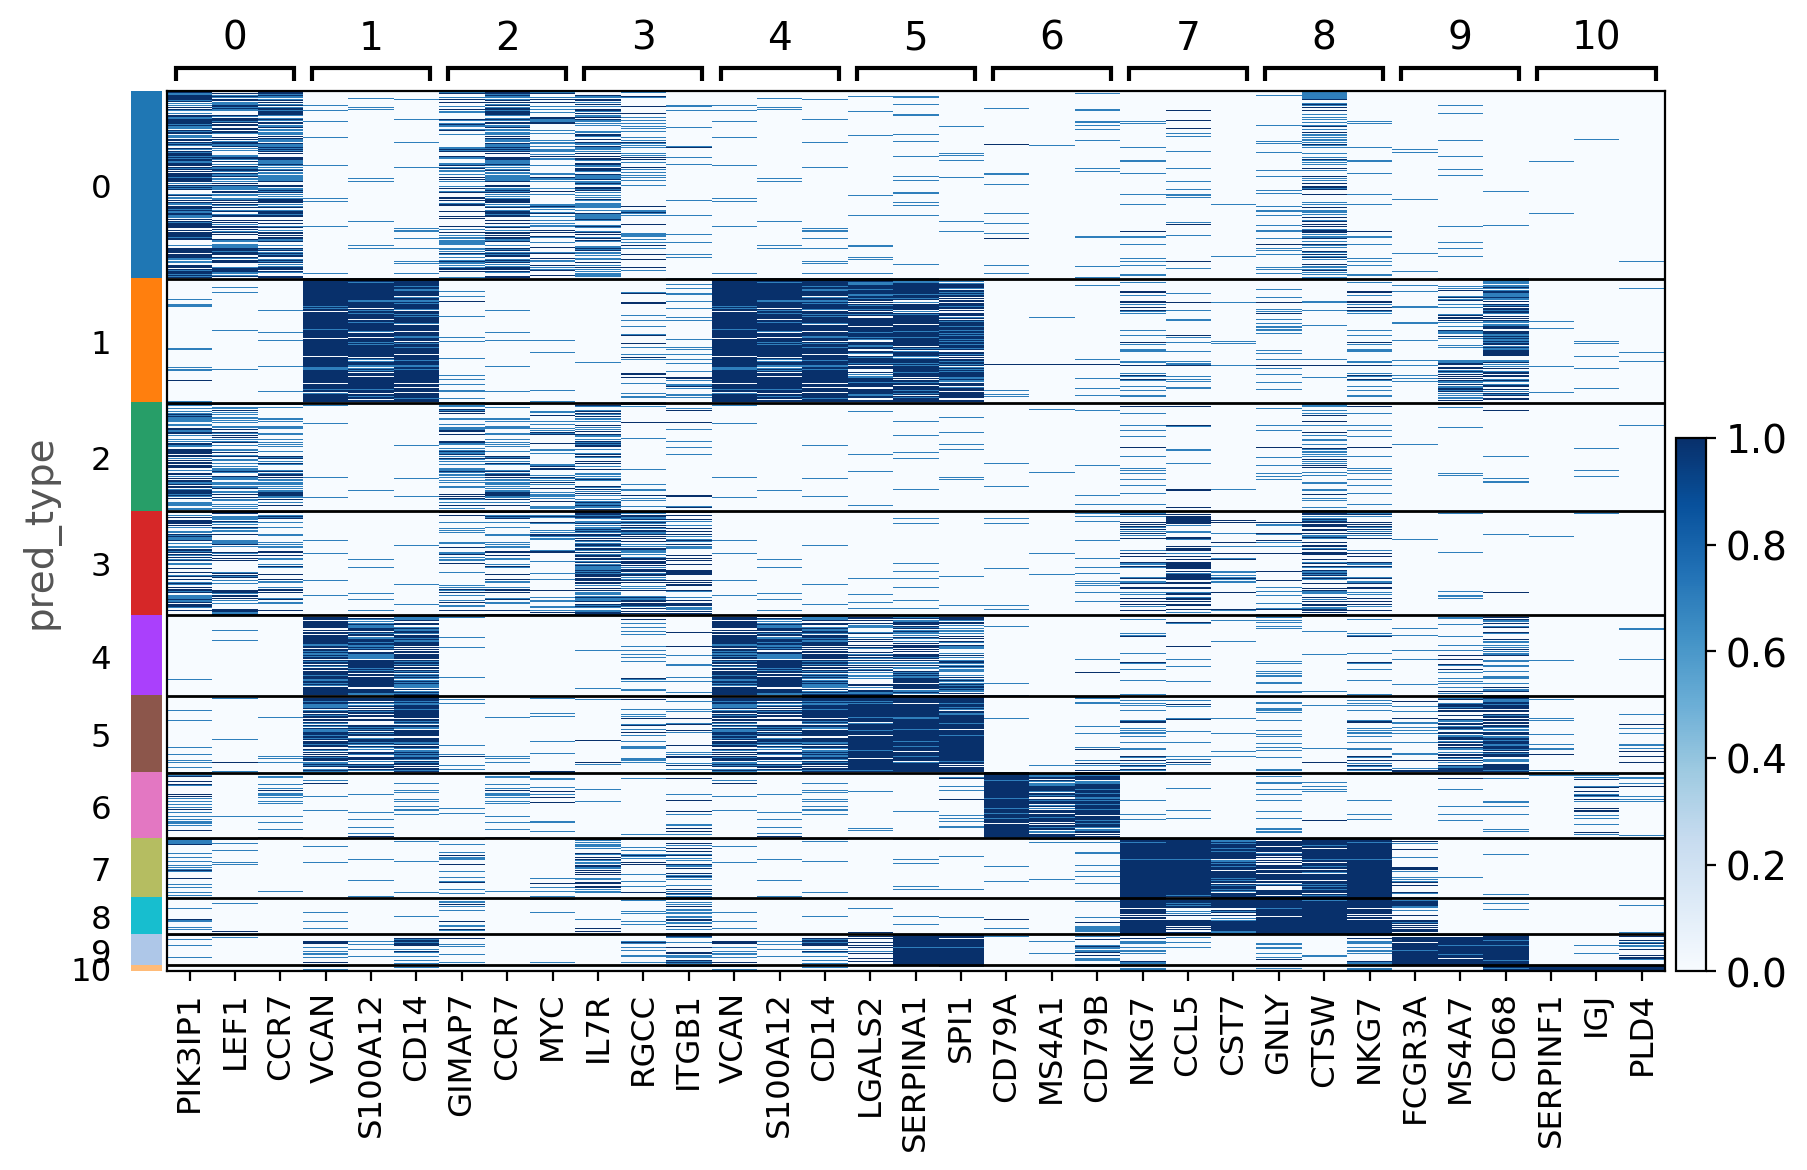

In [64]:
sc.pl.rank_genes_groups_heatmap(
    adata_d, 
    n_genes=3, 
    dendrogram=False, 
    show=False,
    key="dea_leiden_res1_filtered",
    vmin=0, 
    vmax=1, 
    cmap="Blues"
)

#### Enrichment analysis

In [27]:
gene_list = degs["names"].tolist()

In [41]:
import gseapy as gp

enrich_results = gp.enrichr(
    gene_list=gene_list,
    #gene_sets=['KEGG_2016', 'GO_Biological_Process_2023'],
    #gene_sets=['KEGG_2016','KEGG_2021_Human'],
    gene_sets=['KEGG_2016'],
    #gene_sets=['Reactome_2022', 'KEGG_2016', 'GO_Biological_Process_2023'],
    organism='human',
    cutoff=0.5,
    outdir=None,
)

sorted_results = enrich_results.results.sort_values(by='Adjusted P-value', ascending=True)
significant_results = sorted_results[sorted_results['Adjusted P-value'] < 0.05]

print(significant_results.head())

    Gene_set                                               Term Overlap  \
0  KEGG_2016   Hematopoietic cell lineage Homo sapiens hsa04640    7/88   
1  KEGG_2016  T cell receptor signaling pathway Homo sapiens...   7/104   
2  KEGG_2016     Primary immunodeficiency Homo sapiens hsa05340    4/37   
3  KEGG_2016  Cell adhesion molecules (CAMs) Homo sapiens hs...   6/142   
4  KEGG_2016       Acute myeloid leukemia Homo sapiens hsa05221    4/57   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.000005          0.000849            0                     0   11.619636   
1  0.000016          0.001282            0                     0    9.695140   
2  0.000183          0.009831            0                     0   16.010505   
3  0.000818          0.031313            0                     0    5.875397   
4  0.000972          0.031313            0                     0    9.958742   

   Combined Score                                 Genes  
0      141

In [40]:
import gseapy as gp

enr = gp.enrichr(
    gene_list=gene_list,              
    gene_sets=['KEGG_2021_Human'],       
    organism='human',
    cutoff=1.0,                         
    outdir=None,
)
res = enr.results.sort_values('Adjusted P-value', ascending=True)
sig = res[res['Adjusted P-value'] <= 0.05] 
print(sig.head(10))


          Gene_set                               Term Overlap   P-value  \
0  KEGG_2021_Human         Hematopoietic cell lineage    7/99  0.000012   
1  KEGG_2021_Human  T cell receptor signaling pathway   7/104  0.000016   
2  KEGG_2021_Human           Primary immunodeficiency    4/38  0.000204   
3  KEGG_2021_Human            Cell adhesion molecules   6/148  0.001015   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.001552            0                     0   10.224638   
1          0.001552            0                     0    9.695140   
2          0.013229            0                     0   15.538824   
3          0.049464            0                     0    5.625428   

   Combined Score                                 Genes  
0      116.268716  CD8B;CD8A;CD5;FLT3LG;CD3G;ITGA6;IL7R  
1      107.111363      ITK;CD8B;CD8A;CD28;CD3G;ICOS;LAT  
2      132.076104                   CD8B;CD8A;ICOS;IL7R  
3       38.777304         CD8B;CD6;CD8A;C

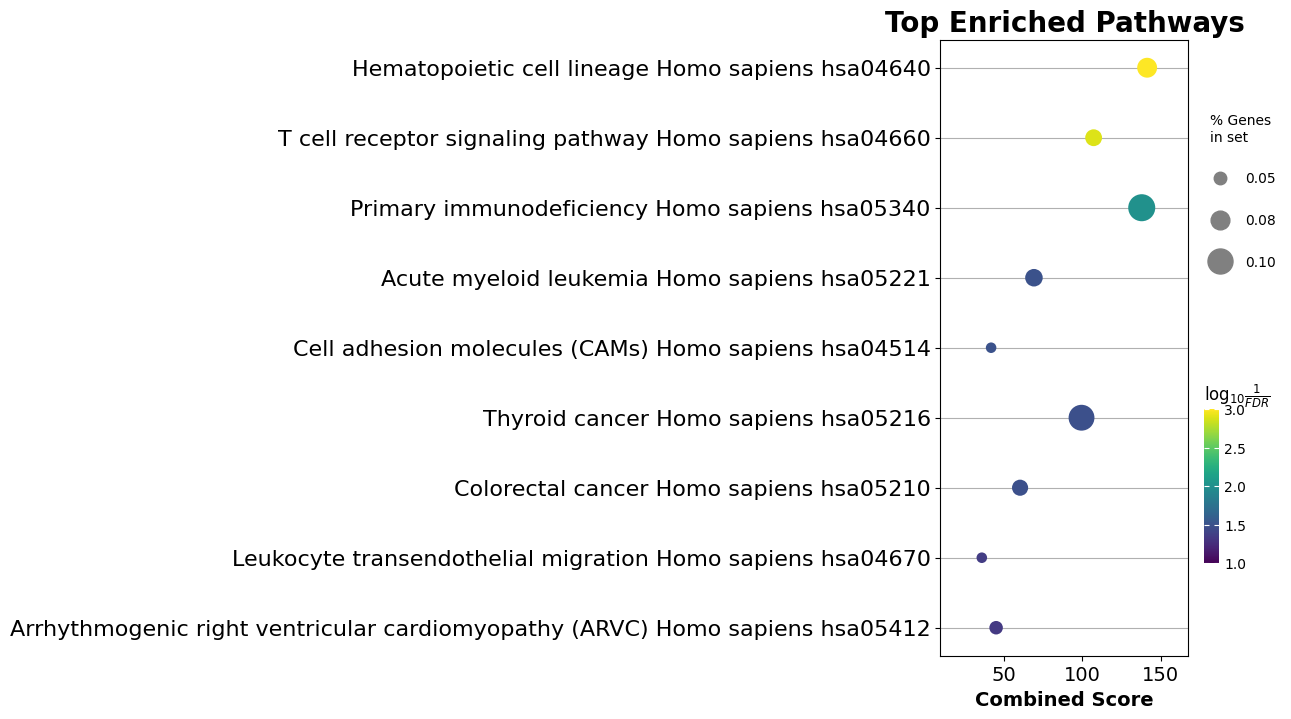

In [43]:
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

ax = gp.dotplot(
    significant_results,
    title='Top Enriched Pathways',
    size=30,
    dot_scale=3.0,
    color='Adjusted P-value',
    top_term=11,
    figsize=(4, 8),
    cmap="viridis",
)

cbar = ax.collections[0].colorbar

cbar.set_label('')

#### Load multi-head attention matrix

In [71]:
import scipy.io
import scipy.sparse as sp
import pandas as pd
import numpy as np
from tqdm import tqdm

def read_mtx_with_abs(path):
    m = scipy.io.mmread(path).tocsr()
    m.data = np.abs(m.data)
    return m

heads = []
for i in range(1, 9):
    matrix = read_mtx_with_abs(
        f'/users/PCON0022/shiya/Database/single/data1_example/cSLE4/output_A_n/attention_matrices/head-{i}.mtx'
    )
    heads.append(matrix.T)

max_matrix = sp.lil_matrix(heads[0].shape)
for i in tqdm(range(heads[0].shape[0]), desc="Processing cells"):
    row_blocks = [m.getrow(i).toarray()[0] for m in heads]
    max_matrix[i] = np.max(row_blocks, axis=0)

max_matrix = max_matrix.tocsr()

Processing cells: 100%|██████████| 5980/5980 [01:26<00:00, 69.48it/s]


In [72]:
adata.layers['max_attention'] = max_matrix
adata.layers['raw'] = RNA_matrix.transpose()

In [30]:
import os

save_dir = "/users/PCON0022/shiya/Database/single/adata/SLE/data1"
save_path = os.path.join(save_dir, "cSLE4_adata.h5ad")

os.makedirs(save_dir, exist_ok=True)

adata.write(save_path)

print(f"adata 已保存到: {save_path}")

adata 已保存到: /users/PCON0022/shiya/Database/single/adata/SLE/rare10/cSLE4_adata.h5ad


In [61]:
max_matrix

<5980x16227 sparse matrix of type '<class 'numpy.float64'>'
	with 1077428 stored elements in Compressed Sparse Row format>

In [75]:
adata_max_matrix = sc.AnnData(
    X=max_matrix,
    obs=adata.obs.copy(),
    var=adata.var.copy()
)

adata_max_matrix.obs['pred_type'] = adata_max_matrix.obs['pred_type'].astype('category')

sc.pp.pca(adata_max_matrix, n_comps=50)
sc.tl.dendrogram(adata_max_matrix, groupby='pred_type')

sc.tl.rank_genes_groups(
    adata_max_matrix, 
    groupby="pred_type",
    use_rep='X_pca',
    method="wilcoxon", 
    key_added="dea_leiden_res1"
)
degs_max_matrix = sc.get.rank_genes_groups_df(adata_max_matrix, group='0', key='dea_leiden_res1')

head1_names_max = degs_max_matrix['names']
head1_names_max[0:60]

0           LTB
1          CD3E
2          CD3D
3       PIK3IP1
4           AES
5           EVL
6         NOSIP
7         HSPA8
8           CD7
9        IFITM1
10      ZFP36L2
11         LDHB
12         IL32
13         CD3G
14      RPSAP58
15         SELL
16       EEF1B2
17      C6orf48
18         CCR7
19     LEPROTL1
20         CD27
21         TOB1
22          LCK
23        CALM1
24         LEF1
25          UBB
26        SNHG8
27          LAT
28        HMGN1
29       ARRDC3
30        RGS10
31        CXCR4
32         ST13
33         GYPC
34        ISG20
35     TRAF3IP3
36        HLA-E
37         IL7R
38     CDC42SE2
39        SATB1
40      TSC22D3
41         TCF7
42    LINC00861
43        CCND3
44         SUN2
45        IL2RG
46      PTPRCAP
47       EIF4A2
48          ATM
49       RSL1D1
50        EIF3H
51        ACAP1
52     HSP90AB1
53        TXNIP
54         PIM2
55        PNISR
56          JUN
57         RBMX
58        TSTD1
59        CIRBP
Name: names, dtype: object

#### Compute the attention difference only between class 0 and class 1

In [49]:
max_matrix_csr = max_matrix.tocsr()

adata_max_matrix = sc.AnnData(
    X=max_matrix_csr,
    obs=adata.obs.copy(),
    var=adata.var.copy(),
    layers={"max_attention": max_matrix_csr}
)

In [52]:
adata_sub = adata_max_matrix[adata_max_matrix.obs["pred_type"].isin(["0", "1"])].copy()
adata_sub.obs["tmp_group"] = adata_sub.obs["pred_type"].astype(str)

In [53]:
row_idx = adata_max_matrix.obs_names.get_indexer(adata_sub.obs_names)

adata_sub.layers["max_attention"] = adata_max_matrix.layers["max_attention"][row_idx, :]

In [54]:
sc.tl.rank_genes_groups(
    adata_sub,
    groupby="tmp_group",
    groups=["0"],
    reference="1",
    method="wilcoxon",
    key_added="dea_attention_0_vs_1",
    layer="max_attention" 
)

In [55]:
degs_max_matrix = sc.get.rank_genes_groups_df(adata_sub, group='0', key='dea_attention_0_vs_1')
print(degs_max_matrix['names'].head(60))

0       HSPA8
1         LTB
2        CD3E
3         AES
4       RPS28
5       RPS16
6       RPS29
7     HNRNPA1
8       RPLP0
9        RPSA
10        EVL
11      RPL28
12      RPS21
13       CD3D
14    C6orf48
15    PTPRCAP
16     EIF4A2
17     EEF1B2
18        UBB
19     IFITM1
20      CIRBP
21    ZFP36L2
22       CFL1
23      RPL19
24      SNHG8
25      RPS26
26      RGS10
27      CXCR4
28    RSL24D1
29      IL2RG
30     RPS15A
31     EIF4A1
32      RPS27
33       TMA7
34      COX7C
35       LDHB
36    ANAPC16
37      RPL23
38       RPL8
39      ACAP1
40        LCK
41       SUN2
42      SAP18
43     TMBIM6
44       LEF1
45        CD7
46     UBE2D2
47       NACA
48      SRRM1
49      NOSIP
50      RPS13
51      RPS18
52      TXNIP
53       STK4
54    HNRNPA0
55      RPL38
56      HMGB1
57      RPS23
58       RAC2
59      CALM3
Name: names, dtype: object


In [32]:
import pandas as pd

pred_types = adata_max_matrix.obs['pred_type'].cat.categories.tolist()
type_mapping = (
    adata_max_matrix.obs[['pred_type', 'mapped_pred_type']]
    .drop_duplicates()
    .set_index('pred_type')['mapped_pred_type']
    .str.split(':', expand=True)[1]
    .str.strip()
    .to_dict()
)

dfs = []
for pt in pred_types:
    deg_df = sc.get.rank_genes_groups_df(adata_max_matrix, group=str(pt), key='dea_leiden_res1')
    
    columns = []
    for i, col in enumerate(deg_df.columns):
        if i == 0:
            columns.append((f'Cluster {pt}', type_mapping[pt]))  
        else:
            columns.append((f'Cluster {pt}', col))
    
    deg_df.columns = pd.MultiIndex.from_tuples(columns, names=['pred_type', 'mapped/stat'])
    
    dfs.append(deg_df)

combined_degs = pd.concat(dfs, axis=1)

In [169]:
combined_degs

pred_type   Cluster 0                                                        \
mapped/stat   CD8+ Tn     scores logfoldchanges         pvals     pvals_adj   
0                 LTB   9.638920       0.866140  5.476116e-22  1.481016e-18   
1                CD3E   8.953074       1.313952  3.457181e-19  4.674973e-16   
2                CD3D   7.759348       1.389731  8.536723e-15  5.130571e-12   
3             PIK3IP1   7.107051       1.613779  1.185486e-12  4.691922e-10   
4                 AES   6.862444       0.762772  6.769212e-12  2.337107e-09   
...               ...        ...            ...           ...           ...   
16222            RPS8  -9.776946      -0.891942  1.414126e-22  4.589404e-19   
16223           HLA-B -10.357547      -0.837496  3.867538e-25  1.568963e-21   
16224           RPS18 -11.064427      -0.866668  1.866515e-28  1.009598e-24   
16225           RPL12 -11.898483      -0.800389  1.205176e-32  9.778195e-29   
16226           RPL7A -14.170918      -0.779787  1.386759e-45  2.250294e-41   

pred_type   Cluster 1                                                        \
mapped/stat       cM1     scores logfoldchanges         pvals     pvals_adj   
0                FCN1  11.005486       1.759431  3.595701e-28  5.834744e-24   
1                LST1  10.817569       1.408082  2.842158e-27  2.305985e-23   
2               RPL7A   8.486934       0.259317  2.121606e-17  8.606825e-14   
3                NACA   8.238033       0.382229  1.750648e-16  5.681554e-13   
4              S100A9   8.164814       0.870450  3.219300e-16  8.706598e-13   
...               ...        ...            ...           ...           ...   
16222          IFITM1  -7.105325      -3.437979  1.200396e-12  1.025201e-09   
16223            CD3E  -7.312671      -3.475306  2.618842e-13  2.833063e-10   
16224             UBB  -7.610448      -0.991736  2.731465e-14  3.409499e-11   
16225             EVL  -7.886734      -2.467297  3.101986e-15  6.208738e-12   
16226             LTB -10.725599      -2.352610  7.718494e-27  4.174933e-23   

pred_type    ... Cluster 9                                          \
mapped/stat  ...       ncM     scores logfoldchanges         pvals   
0            ...     RPL7A  10.661729       1.011321  1.537137e-26   
1            ...      NACA   7.310041       0.917654  2.670606e-13   
2            ...      PTMA   7.087662       1.011958  1.363969e-12   
3            ...     RPL12   7.064399       0.804858  1.613130e-12   
4            ...     HLA-B   6.428907       0.810769  1.285247e-10   
...          ...       ...        ...            ...           ...   
16222        ...      CD3D  -2.475405      -2.023916  1.330852e-02   
16223        ...      SELL  -2.697033      -1.496843  6.996031e-03   
16224        ...   PTPRCAP  -2.842701      -2.687544  4.473297e-03   
16225        ...       AES  -3.073769      -1.254680  2.113731e-03   
16226        ...      CD3E  -3.288861      -2.477921  1.005938e-03   

pred_type                 Cluster 10                                     \
mapped/stat     pvals_adj       pDCs    scores logfoldchanges     pvals   
0            2.494312e-22       FTH1  4.254143       1.416970  0.000021   
1            2.166796e-09     MT-CO2  3.233167       1.158524  0.001224   
2            6.544065e-09      RPS27  3.190383       0.901006  0.001421   
3            6.544065e-09      RPL7A  3.147869       0.631651  0.001645   
4            4.171139e-07    HLA-DRA  3.089747       1.787097  0.002003   
...                   ...        ...       ...            ...       ...   
16222        9.727812e-01       CD3E -1.553081      -3.737931  0.120404   
16223        6.231571e-01      PNRC1 -1.663717      -0.656486  0.096169   
16224        4.653089e-01       FCN1 -1.689549     -27.475506  0.091114   
16225        2.559665e-01     IFITM1 -1.708384     -27.348207  0.087565   
16226        1.431873e-01        EVL -1.899789      -3.069321  0.057461   

pred_type              
mapped/stat pvals_adj  
0        

In [33]:
save_dir = "/users/PCON0022/shiya/Database/single/attention_score/SLE/data1"
file_name = "cSLE4_att.csv" 
file_path = os.path.join(save_dir, file_name)

# save combined_degs to CSV
combined_degs.to_csv(file_path, index=False, encoding='utf-8')

print(f"文件已保存至: {file_path}")

文件已保存至: /users/PCON0022/shiya/Database/single/attention_score/SLE/rare10/cSLE4_att.csv


In [113]:
# max
max_matrix = sp.lil_matrix(heads[0].shape)
for i in tqdm(range(heads[0].shape[0])):
    row_blocks = [m.getrow(i).toarray()[0] for m in heads]
    max_matrix[i] = np.max(row_blocks, axis=0)

100%|██████████| 5980/5980 [01:33<00:00, 64.05it/s]


In [32]:
# average
mean_matrix = sp.lil_matrix(heads[0].shape)
for i in tqdm(range(heads[0].shape[0])):
    row_blocks = [m.getrow(i).toarray()[0] for m in heads]
    mean_matrix[i] = np.mean(row_blocks, axis=0)

100%|██████████| 5980/5980 [01:35<00:00, 62.70it/s]


In [114]:
pred_types = adata.obs['pred_type'].values
gene_names = adata.var_names.tolist()

In [115]:
def get_top30(matrix, pred_types, gene_names):
    df = pd.DataFrame(matrix.toarray(), columns=gene_names)
    df['cell_type'] = pred_types
    return df.groupby('cell_type').agg(lambda x: x.mean()).apply(
        lambda row: row.nlargest(200).index.tolist(), axis=1)

In [ ]:
max_result = get_top30(max_matrix.tocsr(), pred_types, gene_names)
mean_result = get_top30(mean_matrix.tocsr(), pred_types, gene_names)

In [119]:
mean_result = get_top30(mean_matrix.tocsr(), pred_types, gene_names)

In [116]:
max_result = get_top30(max_matrix.tocsr(), pred_types, gene_names)

In [117]:
max_result

cell_type
0     [PFDN5, MT-CO2, MT-CO1, MT-CO3, MT-ND4, MT-ND2...
1     [RPL7A, RPL12, PFDN5, NACA, RPL26, HLA-B, PTMA...
10    [MT-CO2, FTH1, RPL7A, MT-CO1, OAZ1, PFDN5, MT-...
2     [PFDN5, RPL7A, MT-CO3, MT-CO1, MT-CO2, FTH1, M...
3     [MT-CO3, PFDN5, MT-CO1, MT-CO2, OAZ1, MT-ND4, ...
4     [MT-CO1, PFDN5, MT-CO3, MALAT1, MT-ND4, MT-CO2...
5     [RPL7A, RPL12, NACA, RPS20, PFDN5, RPS18, RPS1...
6     [MT-CO1, MT-CO3, OAZ1, MT-CO2, PFDN5, SERF2, F...
7     [RPL7A, RPL12, RPS15A, RPS18, NACA, RPL26, RPS...
8     [PFDN5, MT-CO2, ACTB, MT-CO3, MT-ND4, UBB, MT-...
9     [RPL7A, RPL12, NACA, PTMA, PFDN5, HLA-B, B2M, ...
dtype: object

In [128]:
def format_result(result, method_name):
    col_name = f'Top30_Genes_{method_name}'
    return pd.DataFrame({
        'Cell_Type': result.index,
        col_name: result.values
    }).explode(col_name).reset_index(drop=True)

final_df = pd.merge(
    format_result(max_result, 'Max'),
    format_result(mean_result, 'Mean'),
    left_on=['Cell_Type', 'Top30_Genes_Max'],
    right_on=['Cell_Type', 'Top30_Genes_Mean'],
    how='outer'
).rename(columns={
    'Top30_Genes_Max': 'Max_Method_Gene',
    'Top30_Genes_Mean': 'Mean_Method_Gene'
})

In [129]:
final_df

Cell_Type Max_Method_Gene Mean_Method_Gene
0           0           PFDN5            PFDN5
1           0          MT-CO2           MT-CO2
2           0          MT-CO1           MT-CO1
3           0          MT-CO3           MT-CO3
4           0          MT-ND4           MT-ND4
..        ...             ...              ...
688         9             NaN           MT-ND5
689         9             NaN            H3F3A
690         9             NaN              FOS
691         9             NaN         SH3BGRL3
692         9             NaN         HLA-DRB5

[693 rows x 3 columns]

In [104]:
def create_results_df(results_dict, method_name):
    max_len = max(len(genes) for genes in results_dict.values())
    
    columns = pd.MultiIndex.from_product([
        [method_name], 
        [f'Top{i+1}' for i in range(max_len)]
    ])
    
    data = []
    for cell_type in sorted(results_dict.keys(), key=int):
        genes = results_dict[cell_type]
        padded_genes = genes + [None]*(max_len - len(genes))  # 填充空值保持形状一致
        data.append(padded_genes)
    
    return pd.DataFrame(data, 
                       index=sorted(results_dict.keys(), key=int),
                       columns=columns)

max_df = create_results_df(max_results, 'Max_Attention')
mean_df = create_results_df(mean_results, 'Mean_Attention')

In [105]:
max_df

Max_Attention                                                           \
            Top1    Top2    Top3    Top4    Top5    Top6    Top7     Top8   
0          PFDN5  MT-CO2  MT-CO1  MT-CO3  MT-ND4  MT-ND3  MT-ND2     ACTB   
1          RPL7A   RPL12   PFDN5    NACA   RPL26   HLA-B    PTMA   MT-ND2   
2         MT-CO3   PFDN5  MT-CO1  MT-CO2    FTH1  MT-ND3  MT-ND4   MT-ND2   
3         MT-CO3   PFDN5  MT-CO1  MT-CO2    OAZ1  MT-ND4  MT-ND3   MT-ND2   
4         MT-CO1   PFDN5  MT-CO3  MT-ND4  MT-CO2    OAZ1   SERF2   MT-ND2   
5          RPL7A   PFDN5   RPL12  MT-CO3    NACA   RPS20  MT-ND3    PCBP1   
6         MT-CO1  MT-CO3    OAZ1  MT-CO2   PFDN5   SERF2    FTH1   MT-ND4   
7          PFDN5  MT-CO1  MT-CO2  MT-CO3  MT-ND2   SERF2  MT-ND4   S100A6   
8          PFDN5  MT-CO2    ACTB  MT-CO3  MT-ND4  MT-ND3  MT-CO1  MT-ATP6   
9          RPL7A   PFDN5   RPL12    NACA    PTMA  MT-ND2   HLA-B      B2M   
10        MT-CO2    FTH1  MT-CO1    OAZ1  MT-ND3   PFDN5  MT-ND1   S100A6   

                     ...                                                    \
       Top9   Top10  ...     Top21     Top22     Top23     Top24     Top25   
0      FTH1   SERF2  ...    MT-ND5     PCBP1    ATP5G2  SH3BGRL3     ATP5E   
1     RPS4X   ITM2B  ...       B2M     RPS18     RPS15     RPL29       FAU   
2      ACTB   SERF2  ...  SH3BGRL3    ATP5G2       FOS     PNRC1    NFKBIA   
3     SERF2    ACTB  ...       FOS     ITM2B     PNRC1    MT-ND5     PCBP1   
4   MT-ATP6  MT-ND3  ...       VIM  SH3BGRL3       FOS     ITM2B    MT-ND1   
5   MT-ATP6  MT-CO2  ...     RPS4X      RPS8    EEF1A1    MT-ND4    S100A6   
6      ACTB  MT-ND3  ...       FOS  HLA-DRB1    MT-ND5    ATP5G2  HLA-DRB5   
7      FTH1    OAZ1  ...     DUSP1     ZFP36  SH3BGRL3    MT-ND5     ITM2B   
8     SERF2     FOS  ...     PNRC1    S100A4  SH3BGRL3     DUSP1      MYL6   
9     RPS18   RPL26  ...     ITM2B      RPS8     RPL10      RPL9     RPL28   
10     MYL6   SERF2  ...     CLIC1       FTL  PPP1R15A      ACTB    MT-ND5   

                                             
     Top26  Top27   Top28   Top29     Top30  
0   S100A4    VIM    LY6E   COX5B      CYBA  
1   MT-CO3  RPL31   RPL32   SERF2    EEF1A1  
2   S100A4    VIM   H3F3A   ATP5E     GAPDH  
3   ATP5G2  CALM2   CCNL1   ZFP36      CYBA  
4     FTH1   LY6E  S100A8    MYL6     PCBP1  
5    RPL26   ACTB   HLA-B     FAU     RPS14  
6     LY6E  ZFP36   RPL7A   CALM2  SH3BGRL3  
7    GAPDH  CALM2   ATP5E   PCBP1     PNRC1  
8    ITGB2  ITM2B   CLIC1  IFITM2      CD74  
9    HLA-C  RPL29  EEF1A1   PNRC1    MALAT1  
10   ATP5E  H3F3A   ZFP36   PCBP1      CST3  

[11 rows x 30 columns]

In [106]:
mean_df

Mean_Attention                                                              \
             Top1     Top2    Top3    Top4     Top5     Top6    Top7     Top8   
0           PFDN5   MT-CO1  MT-CO2  MT-CO3   MT-ND4   MT-ND3  MT-ND2     FTH1   
1           PFDN5   MT-ND2  MT-CO2   ITM2B   MT-ND4   MT-CO3   SERF2    RPL7A   
2          MT-CO1     FTH1  MT-CO3   PFDN5   MT-CO2   MT-ND3  MT-ND4     ACTB   
3          MT-CO3    PFDN5  MT-CO1    OAZ1   MT-CO2   MT-ND3  MT-ND4    SERF2   
4            JUNB      JUN     UBB   HLA-E  ZFP36L2  TSC22D3   HLA-A    TXNIP   
5           PFDN5   MT-CO3   RPL7A  MT-ND2   MT-ND1  MT-ATP6  MT-ND3    PCBP1   
6          MT-CO1   MT-CO3    OAZ1  MT-CO2    PFDN5     FTH1  MT-ND1   MT-ND3   
7          MT-CO1   S100A6    FTH1  MT-CO2    PFDN5   MT-CO3  S100A4     OAZ1   
8           PFDN5   MT-CO3    ACTB  MT-CO2   MT-ND4   MT-ND3   SERF2  MT-ATP6   
9           PFDN5   MT-ND2  MT-CO1  MT-ND3    CALM2   MT-ND4  MT-CO3     OAZ1   
10           FTH1  HLA-DRA  MT-CO2   CALM2     OAZ1     CD74  MT-CO1     CYBA   

                    ...                                                    \
      Top9   Top10  ...     Top21     Top22     Top23     Top24     Top25   
0     OAZ1   SERF2  ...     ITM2B     PCBP1    ATP5G2  SH3BGRL3       VIM   
1   MT-ND3  MT-CO1  ...     HLA-B     RPL26   MT-ATP6    ATP5G2     RPS4X   
2   MT-ND2   SERF2  ...    ATP5G2     PNRC1    S100A4     DUSP1     H3F3A   
3   MT-ND2  S100A4  ...     PNRC1       FOS      CYBA     PCBP1    MT-ND5   
4    CALM1    CD99  ...      RGS1      GNLY   C1orf63      SUN2  HNRNPUL1   
5   MT-CO2  MT-CO1  ...     ATP5E      PTMA     RPS18    ATP5G2    DAZAP2   
6    SERF2  MT-ND4  ...       FOS  HLA-DRB1  HLA-DRB5     ZFP36    ATP5G2   
7    SERF2  NFKBIA  ...  SH3BGRL3    MT-ND3   MT-ATP6     CALM2    MT-ND5   
8   MT-CO1  MT-ND2  ...       FTL  SH3BGRL3    S100A4     DUSP1      MYL6   
9    PNRC1  MT-CO2  ...   C14orf2    S100A6     COX5B    DAZAP2     PCBP1   
10    ACTB  S100A6  ...       VIM   C14orf2    ATP5G2     H2AFY     DUSP1   

                                                    
      Top26     Top27     Top28    Top29     Top30  
0     ATP5E    S100A4      CYBA     LY6E     COX5B  
1    S100A6    RPS15A       FAU    RPS19     RPS18  
2      CD74       FOS       VIM    ATP5E     GAPDH  
3     ITM2B     CCNL1     CALM2    ZFP36      MYL6  
4   ARHGEF1  CDC42SE2      RGCC  PPP2R5C      RAC2  
5    EEF1A1      RPS8     RPLP1    RPS4X     EEF1D  
6      LY6E    MT-ND5  PPP1R15A    ATP5E  SH3BGRL3  
7     PCBP1     ATP5E      CD74    H3F3A     PNRC1  
8     ITGB2    IFITM2     CLIC1   DAZAP2      CD74  
9     GAPDH     ATP5E   MT-ATP6      FTL      EMP3  
10   MT-ND3    MT-ND1    MT-ND4   FKBP1A   HLA-DMA  

[11 rows x 30 columns]

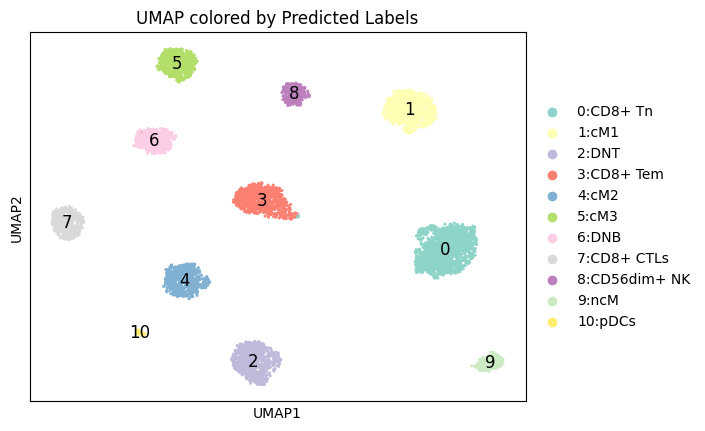

In [173]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

adata1 = sc.AnnData(cell_embedding)

label_mapping = {
    0: '0:CD8+ Tn',
    1: '1:cM1',
    2: '2:DNT',
    3: '3:CD8+ Tem',
    4: '4:cM2',
    5: '5:cM3',
    6: '6:DNB',
    7: '7:CD8+ CTLs',
    8: '8:CD56dim+ NK',
    9: '9:ncM',
    10: '10:pDCs'
}
pred_label_mapped = pd.Categorical([label_mapping[int(x)] for x in pred_label])
adata1.obs['pred_label'] = pred_label_mapped

sc.pp.neighbors(adata1, n_neighbors=15, use_rep='X')
sc.tl.umap(adata1)

sorted_labels = sorted(pred_label_mapped.categories, key=lambda x: int(x.split(':')[0]))
palette = sns.color_palette("Set2", len(sorted_labels)) 

adata1.obs['pred_label'] = pd.Categorical(adata1.obs['pred_label'], categories=sorted_labels, ordered=True)

def compute_centroids(adata1, label_key):
    labels = adata1.obs[label_key].cat.categories
    centroids = np.vstack([adata1.obsm['X_umap'][adata1.obs[label_key] == label].mean(axis=0) for label in labels])
    return labels, centroids

def plot_umap_with_numbers(adata1, label_key, title, palette):
    sc.pl.umap(adata1, color=label_key, palette=palette, title=title, show=False)
    labels, centroids = compute_centroids(adata1, label_key)
    ax = plt.gca()
    for label, centroid in zip(labels, centroids):

        number = int(label.split(':')[0])
        ax.text(centroid[0], centroid[1], str(number), fontsize=12, ha='center', va='center')
    plt.show()

plot_umap_with_numbers(adata1, 'pred_label', 'UMAP colored by Predicted Labels', 'Set3')
